# Template Runner 003
This is a simple spectral masking (cross-correlation) based approach. We extract and generate a template, and then cross-correlate with peak detection. We export the template and the parameters used to a .h (header file) for export on the CARACAL ARM M4F board.

We run the template

In [1]:
import librosa
import pylab as plt
import numpy as np
import pickle
import scipy # Unused

In [2]:
WORKING_DIR = 'C:/Users/Amogh/OneDrive - University of Cambridge/Programming-New/CaracalChitalDetector/'
FILEPREFIX = "data/py_obj/templateMaker003_001" 

# Step 0: Load the template (generated earlier)

In [3]:
# Get the saved template object
with open(WORKING_DIR + FILEPREFIX + ".pkl",'rb') as f:
    templateObj = pickle.load(f)

tList = templateObj['tList']
DATECODE = templateObj["DateCode"] # Unused
ML_SR = templateObj['ML_SR']
SPECD_FFT_LEN = templateObj['SPECD_FFT_LEN']
ML_BIN_AGG = templateObj['ML_BIN_AGG']
ML_FLO = templateObj['ML_FLO']
ML_FHI = templateObj['ML_FHI']
ML_FFT_STRIDE = templateObj['ML_FFT_STRIDE']
WIN_LENGTH =  templateObj['WIN_LENGTH']
WIN_ALPHA = templateObj['WIN_ALPHA']
INIT_WINDEV = templateObj["INIT_WINDEV"]
WIN_ALPHA_MEAN = templateObj['WIN_ALPHA_MEAN']

In [4]:
filename = "file_1711182420.wav"

startT = 0 # Time in seconds to extract a useful clip from
endT = 15*60
gtT = [44,45.7,46.6, 48.9,49.55,51.8,52.1,54.0,54.7,58.4,61.0,62.4,66.9,67.5,69.3,71.2,72.1,72.4] # Ground Truth call times

aud, sr = librosa.load(filename,sr=ML_SR)
print(f"File Samples: {np.shape(aud)}, Rate:{sr}")

aud = aud[startT*sr:endT*sr]
print(f"Clipped Samples: {np.shape(aud)}, Rate:{sr}")

File Samples: (15851520,), Rate:8000
Clipped Samples: (7200000,), Rate:8000


# Step 1:

Convert the wav file to FFT. We then extract out our "feature map" which is just the spectral magnitude bins. We do a simple boxcar aggregate, but we could use a triangular weighting quite easily as well.

In [5]:
def chunkToBins(chunk,fLo,fHi,numbins,sr):
    """convert a chunk (window) to slope.
    Provide the low and high frequencies in Hz for a spectral windowing
    numbins are the number of output bins between flo and fhi
    Provide the sample rate in Hz"""
    CMPLX_FFT_LEN = len(chunk) * 2 
    
    fS = np.fft.fft(chunk,n=CMPLX_FFT_LEN) # fft - note we double it for the cmplx fft
    fRes = sr / (CMPLX_FFT_LEN)   # frequency per cmplx bin
    #print(fRes)
    binLo = int(fLo / sr * CMPLX_FFT_LEN)
    binHi = int(fHi / sr * CMPLX_FFT_LEN)
    specSize = int((binHi - binLo) / numbins)
    binTotals = np.zeros(numbins)
    for k in range(numbins):
        dbSum = 0
        for j in range(specSize):
            idx = binLo + (k * numbins) + j      # Amogh - Should numbins be changed to size of each bin instead?
            dbVal = np.log10(np.abs(fS[idx]))
            dbSum += dbVal
        binTotals[k] = dbSum
    return binTotals
q = chunkToBins(aud[:SPECD_FFT_LEN], ML_FLO, ML_FHI, ML_BIN_AGG, ML_SR)
print(q)

[-2.80625511 -2.84633834 -3.11733469 -3.21830181 -3.23162485 -3.23279178
 -3.77741674 -3.10251884]


# Step 2: Show the template

-1.7910577789828617 1.7910577789828617


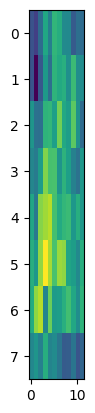

In [6]:
print(np.min(tList), np.max(tList))

plt.imshow(tList.T, aspect=10)
plt.show()

# Step 3: Slide the window and correlate

We manually compute the correlation, so it is directly the same as our high-tech C code.

(28125, 8) (12, 8)
(28113,)


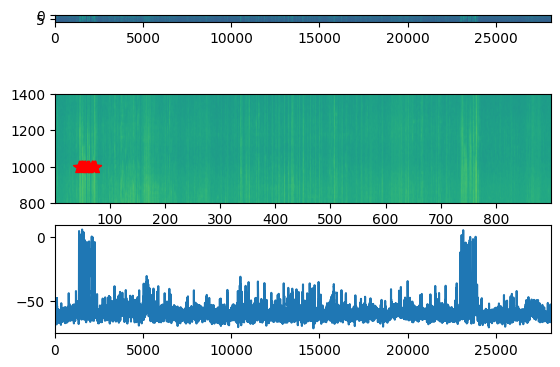

In [7]:
qList = []
for idx in range(0, len(aud), int(ML_FFT_STRIDE)):
    clip = aud[idx:idx+SPECD_FFT_LEN]
    q = chunkToBins(clip, ML_FLO, ML_FHI, ML_BIN_AGG, ML_SR)
    
    qList.append(q)
qList = np.array(qList)

# Now we cross correlate
print(np.shape(qList), np.shape(tList))
xcorr = []
for offset in range(len(qList) - np.shape(tList)[0]):
    xcTotal = 0
    for tIdx in range(np.shape(tList)[0]):
        for bIdx in range(ML_BIN_AGG):
            xcTotal += qList[offset+tIdx][bIdx]*tList[tIdx][bIdx]
    xcorr.append(xcTotal)
xcorr = np.array(xcorr)


print(np.shape(xcorr))


plt.subplot(311)
plt.imshow(qList.T,aspect=50)
plt.xlim(0,len(qList))
plt.subplot(312)
plt.specgram(aud,Fs=8000,NFFT=1024,noverlap=800)
plt.ylim(800,1400)
plt.scatter(gtT,np.ones(len(gtT))*1000,c='red',marker='*',s=80)
plt.subplot(313)
plt.plot((xcorr))
plt.xlim(0,len(xcorr))
plt.show()

# Step 4: Peak Detection

This is loosely based on https://stackoverflow.com/questions/22583391/peak-signal-detection-in-realtime-timeseries-data/54507140#54507140

But made simpler to work neatly on the MCU.

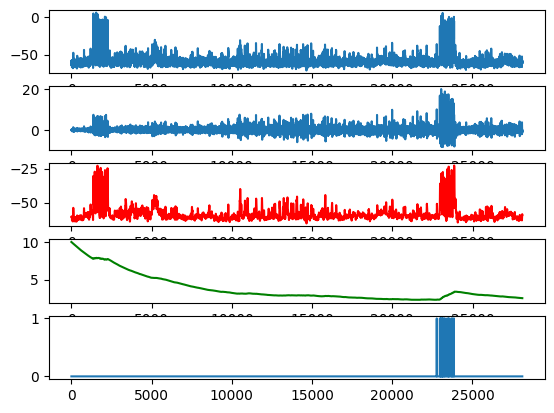

In [8]:
WIN_HOP = 1
WIN_THRESHOLD = 10
#WIN_LENGTH = 15

dets = []
scaled_vals = []
devs = []
means = []

for k in range(WIN_LENGTH):
        dets.append(0)
        scaled_vals.append(0)

winDev = INIT_WINDEV
alpha = WIN_ALPHA
winMean = np.mean(xcorr[:WIN_LENGTH])
alpha_mean = WIN_ALPHA_MEAN

for idx in range(0, len(xcorr) - WIN_LENGTH, WIN_HOP):
    # This is our circular window
    extract = np.array(xcorr[idx:idx+WIN_LENGTH])
    
    winDev = (alpha * np.std(extract)) + ((1 - alpha) * winDev)
    devs.append(winDev)
    
    winMean = (alpha_mean * np.mean(extract)) + ((1 - alpha_mean) * winMean)
    means.append(winMean)
    
    det = 0
    if ((extract[-1] - winMean) / winDev) > WIN_THRESHOLD:
        det = 1
    
    scaled_vals.append((extract[-1] - winMean) / winDev)
    dets.append(det)

plt.subplot(511)
plt.plot(xcorr)
plt.subplot(512)
plt.plot(scaled_vals)
plt.subplot(513)
plt.plot(means,'r')
plt.subplot(514)
plt.plot(devs,'g')
plt.subplot(515)
plt.plot(dets)

plt.show()